In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
# q_in, q_switch, q_out1, q_out2
EJs = [22, 21, 24, 23]
ECs = [0.25, 0.4, 0.4, 0.28]
gs = [0.15, 0.15, 0.15] # g12, g23, g24
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print(qubit_freqs[0], qubit_freqs[1], qubit_freqs[2], qubit_freqs[3])
print(alphas[0], alphas[1], alphas[2], alphas[3])

6.372742057696335 7.77498011533865 8.342661717476677 6.885510681734878
-0.27581343076221465 -0.4576807972507133 -0.45269668911903693 -0.31017075005341965


In [4]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS

# qram.check_state_mapping(n=3)

In [28]:
times = np.linspace(0, 650, 200)
# times = np.linspace(0, 300, 200)
# times = np.linspace(0, 10, 100)

seq = PulseSequence(start_time=0)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)
qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.04)
qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12) # repeat of pulse 0
qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.18)

# qram.add_const_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07, t_pulse_factor=1)
# qram.add_const_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03, t_offset=-seq.prev_pulse_length(), t_pulse_factor=1)
# qram.add_const_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07, t_offset=-seq.prev_pulse_length()) # repeat of pulse 0
# qram.add_const_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06, t_offset=-seq.prev_pulse_length())
# qram.add_const_pi_pulse(seq, 'eegg', 'eggg', amp=0.04, t_offset=0, t_pulse_factor=1)

# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=57.0470))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggeg'), amp=0.15, t_pulse=105.7047))
# seq.wait(seq.const_pulse(wd=get_wd('eegg', 'eggg'), amp=0.05, t_pulse=110.7383))
# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=1000))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggge'), amp=0.1, t_pulse=87.2483))

[-8.815341288805616, 6.790158176784272, 7.757209636271664, -8.815341288805616, 8.309919289407338]


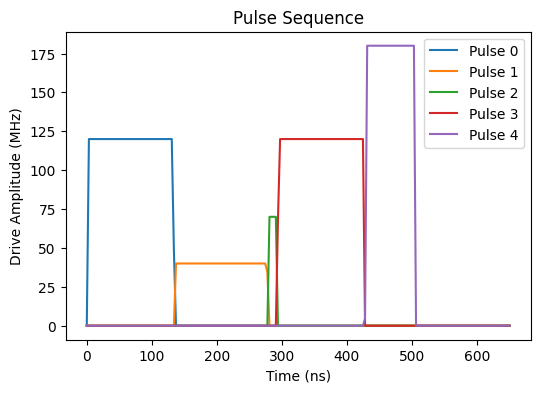

In [29]:
envelope_seq = seq.get_envelope_seq()
print(seq.pulse_freqs)
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [30]:
incl_dissipation = True
# incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*qram.a1,
    np.sqrt(1/T1)*qram.a2,
    np.sqrt(1/T1)*qram.a3,
    np.sqrt(1/T1)*qram.a4,
]

In [31]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(1/2) * qram.state('eggg') + np.sqrt(1/2) * qram.state('eegg') # QRAM start

# print(seq.get_pulse_str())

if incl_dissipation:
    full_result = qt.mcsolve(qram.H_solver_str(seq), psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=10000))
    result = np.sum(full_result.states, axis=0)/full_result.ntraj
else:
    # result = qt.mesolve(qram.H_solver(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states
    result = qt.mesolve(qram.H_solver_str(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states

10.0%. Run time: 4094.52s. Est. time left: 00:10:14:10
20.0%. Run time: 7884.82s. Est. time left: 00:08:45:39
30.0%. Run time: 11993.20s. Est. time left: 00:07:46:24
40.0%. Run time: 15815.04s. Est. time left: 00:06:35:22
50.0%. Run time: 19927.88s. Est. time left: 00:05:32:07
60.0%. Run time: 23751.65s. Est. time left: 00:04:23:54
70.0%. Run time: 27860.51s. Est. time left: 00:03:19:00
80.0%. Run time: 31688.13s. Est. time left: 00:02:12:02
90.0%. Run time: 35786.29s. Est. time left: 00:01:06:16
100.0%. Run time: 39631.89s. Est. time left: 00:00:00:00
Total run time: 39631.90s


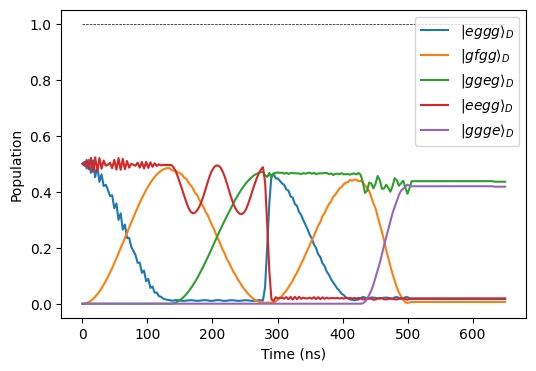

In [32]:
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')

prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]

plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
# plt.xlim(750, 1000)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
plt.show()

In [10]:
T = 700 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                sum_psi += np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
print('Sum probabilities:', sum_psi)
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > 0.01: print(qram.level_nums_to_name([i1, i2, i3, i4]), prob)

Sum probabilities: 0.9796997819822238
Non-zero levels:
gggg 0.013004883388806794
ggge 0.43237151234423415
ggeg 0.4501036285983705
ggee 0.010590023035451928
ggfg 0.013522001788602469
eggg 0.01787362571800814
eegg 0.019668637524677984


In [11]:
print('want', qram.get_wd('eggg', 'eegg')/2/np.pi)
print('resonant to', qram.get_wd('ggeg', 'geeg')/2/np.pi)
print('2 photon transition to', qram.get_wd('eggg', 'efgg')/2/np.pi)

want -7.757209636271662
resonant to -7.632619206493353
2 photon transition to -15.096309020945492


In [12]:
print('want', qram.get_wd('gfgg', 'ggeg')/2/np.pi)
print(qram.get_wd('eegg', 'eege')/2/np.pi)

want 6.790158176784276
-6.801440393632177
